In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost.callback import EarlyStopping
import joblib


In [2]:
df = pd.read_csv('retail_inventory_dataset.csv')
df['date'] = pd.to_datetime(df['date'])

In [3]:
monthly_revenue = df.groupby(df['date'].dt.to_period('M')).revenue.sum().reset_index()
monthly_revenue['date'] = monthly_revenue['date'].dt.to_timestamp()
px.line(monthly_revenue, x='date', y='revenue', title='Total Revenue Over Time').show()


In [4]:
df['stockout_flag'] = df['stockout_flag'].astype(int)

# Count stockouts
stockout_counts = df['stockout_flag'].value_counts().reset_index()
stockout_counts.columns = ['stockout_flag', 'count']
stockout_counts['label'] = stockout_counts['stockout_flag'].map({0: 'No Stockout', 1: 'Stockout'})

# Plot
px.bar(stockout_counts, x='label', y='count', title='Stockout Frequency', text='count').show()


In [5]:
px.box(df, x='promotion_flag', y='units_sold', title='Units Sold: With vs Without Promotions').show()


In [6]:
inventory_trend = df.groupby(df['date'].dt.to_period('M'))['stock_on_hand'].mean().reset_index()
inventory_trend['date'] = inventory_trend['date'].dt.to_timestamp()
px.line(inventory_trend, x='date', y='stock_on_hand', title='Average Inventory Over Time').show()


In [7]:
df['profit'] = df['revenue'] - df['cost'] - df['holding_cost']
profit_by_category = df.groupby('category')['profit'].sum().reset_index()
px.bar(profit_by_category, x='category', y='profit', title='Total Profit by Product Category').show()


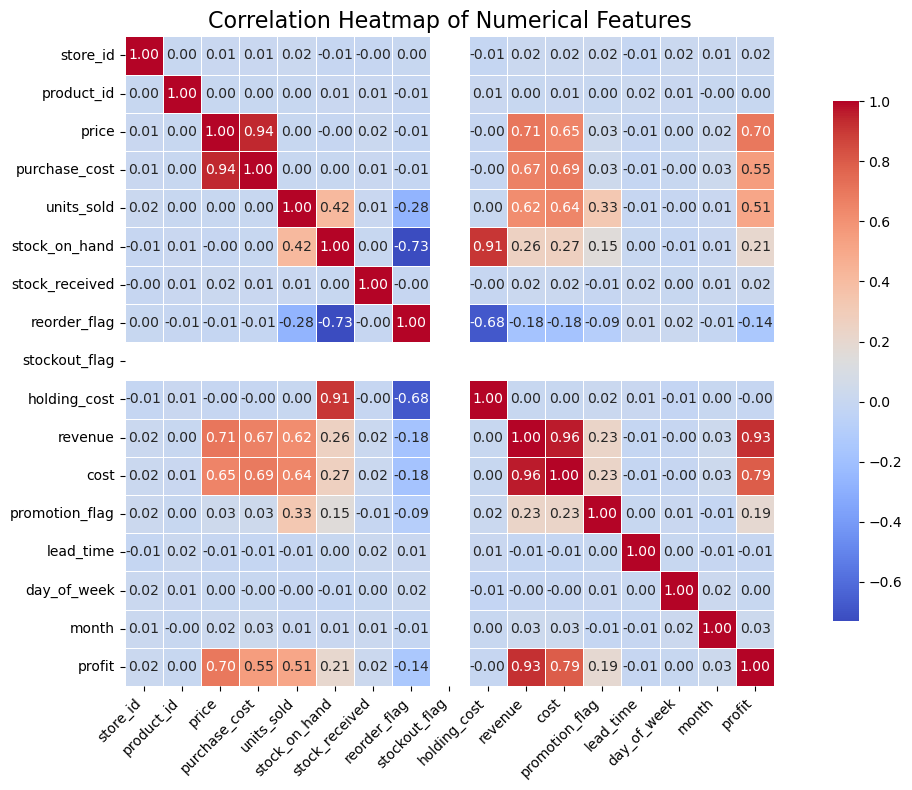

In [8]:
numeric_df = df.select_dtypes(include='number')

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',  # Or use 'RdBu', 'viridis', etc.
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [9]:
revenue_by_store = df.groupby('store_id')['revenue'].sum().reset_index()
px.bar(revenue_by_store, x='store_id', y='revenue', title='Revenue by Store').show()


In [10]:
df_sorted = pd.read_csv('retail_inventory_dataset.csv')

df_sorted['date'] = pd.to_datetime(df_sorted['date'])

df_sorted['day'] = df_sorted['date'].dt.day
df_sorted['month'] = df_sorted['date'].dt.month
df_sorted['year'] = df_sorted['date'].dt.year
df_sorted['day_of_week'] = df_sorted['date'].dt.weekday
df_sorted['is_weekend'] = df_sorted['day_of_week'] >= 5

df_sorted['lag_1'] = df_sorted.groupby(['store_id', 'product_id'])['units_sold'].shift(1)
df_sorted['lag_7'] = df_sorted.groupby(['store_id', 'product_id'])['units_sold'].shift(7)
df_sorted['rolling_mean_7'] = (
    df_sorted.groupby(['store_id', 'product_id'])['units_sold']
    .shift(1).rolling(window=7).mean()
)

df_sorted.fillna(0, inplace=True)
df_sorted['profit'] = df_sorted['revenue'] - (df_sorted['units_sold'] * df_sorted['price'])  




In [11]:
features = [
    'price', 'stock_on_hand', 'promotion_flag', 'day_of_week',
    'lag_1', 'lag_7', 'rolling_mean_7', 'day', 'month', 'is_weekend'
]


X = df_sorted[features]
y = df_sorted['units_sold']


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

evals = [(dtrain, 'train'), (dtest, 'eval')]

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=300,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=10
)

y_pred = model.predict(dtest)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

[0]	train-rmse:2.58799	eval-rmse:2.72233
[10]	train-rmse:2.36304	eval-rmse:2.50191
[20]	train-rmse:2.24612	eval-rmse:2.39657
[30]	train-rmse:2.16708	eval-rmse:2.32941
[40]	train-rmse:2.11484	eval-rmse:2.29165
[50]	train-rmse:2.08723	eval-rmse:2.27664
[60]	train-rmse:2.06556	eval-rmse:2.26901
[70]	train-rmse:2.04993	eval-rmse:2.26682
[80]	train-rmse:2.03468	eval-rmse:2.26705
[90]	train-rmse:2.01617	eval-rmse:2.26661
[100]	train-rmse:1.99894	eval-rmse:2.26855
[101]	train-rmse:1.99713	eval-rmse:2.26878
MAE: 1.76
RMSE: 2.27
R² Score: 0.33


In [13]:
def optimize_inventory(df, model, features, price_col='price'):
    df = df.copy()

    dmatrix = xgb.DMatrix(df[features])
    df['predicted_demand'] = model.predict(dmatrix)

    best_profits = []
    best_qty = []

    for _, row in df.iterrows():
        max_profit = float('-inf')
        best_stock = 0

        if row['revenue'] != 0:
            unit_cost = (row['revenue'] - row['profit']) / max(row['units_sold'], 1)
        else:
            unit_cost = row[price_col] * 0.6  

        for stock in range(0, int(row['predicted_demand'] * 1.5) + 1):
            units_sold = min(stock, row['predicted_demand'])
            revenue = units_sold * row[price_col]
            cost = stock * unit_cost
            holding_cost = (stock - units_sold) * 0.1 * unit_cost  
            profit = revenue - cost - holding_cost

            if profit > max_profit:
                max_profit = profit
                best_stock = stock

        best_profits.append(max_profit)
        best_qty.append(best_stock)

    df['optimized_stock_received'] = best_qty
    df['expected_max_profit'] = best_profits
    return df


df_test = df_sorted.loc[X_test.index].copy()

optimized_df = optimize_inventory(df_test, model, features)

print("\nOptimized Stock and Profit:\n")
print(optimized_df.head(10))


Optimized Stock and Profit:

           date  store_id  product_id         category   price  purchase_cost  \
6252 2024-12-02        30          90         Clothing   72.56          58.96   
4684 2023-10-14         3         374             Toys   63.85          47.80   
1731 2023-08-01        36         179          Grocery   44.17          37.75   
4742 2024-08-09        47         487         Clothing   13.58          11.84   
4521 2023-11-01        45         300           Health  150.39          75.79   
6340 2023-10-29         4         441           Health   84.49          57.43   
576  2024-12-04        11         429         Clothing   93.49          75.54   
5202 2024-02-27        22         416  Home Appliances   60.31          52.35   
6363 2024-12-14        24         373             Toys  114.78          81.83   
439  2023-11-26        34         482           Health   65.35          37.43   

      units_sold  stock_on_hand  stock_received  reorder_flag  ...  day  year 

In [14]:
joblib.dump(model, "xgb_demand_model.pkl")

joblib.dump(model, "xgb_demand_model.pkl")


['xgb_demand_model.pkl']